In [1]:
import numpy as np
import porepy as pp
import scipy.sparse as sps
import sys
import math
sys.path.append("../../class")
from Flow_class import Flow
from Prova_transport_class import Transport

In [2]:
Nx=100
Ny=5

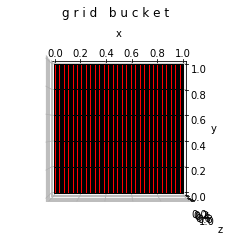

In [3]:
gb, domain = pp.grid_buckets_2d.single_horizontal([Nx, Ny], x_endpoints=[0.2, 0.8], simplex=False)
pp.plot_grid(gb)

In [4]:
parameter={"aperture":1e-3,
          "fracture_perm":1e4,
          "perm":1,
          #"f_lambda":lambda x,y,z:math.pi*math.pi*2*math.sin(math.pi*x)*math.sin(math.pi*y),
          "f_lambda":lambda x,y,z:0.0,
          "bc_value":[1.0,0.0],
          "bc_type":['dir','dir'],
          "method":"Tpfa"}

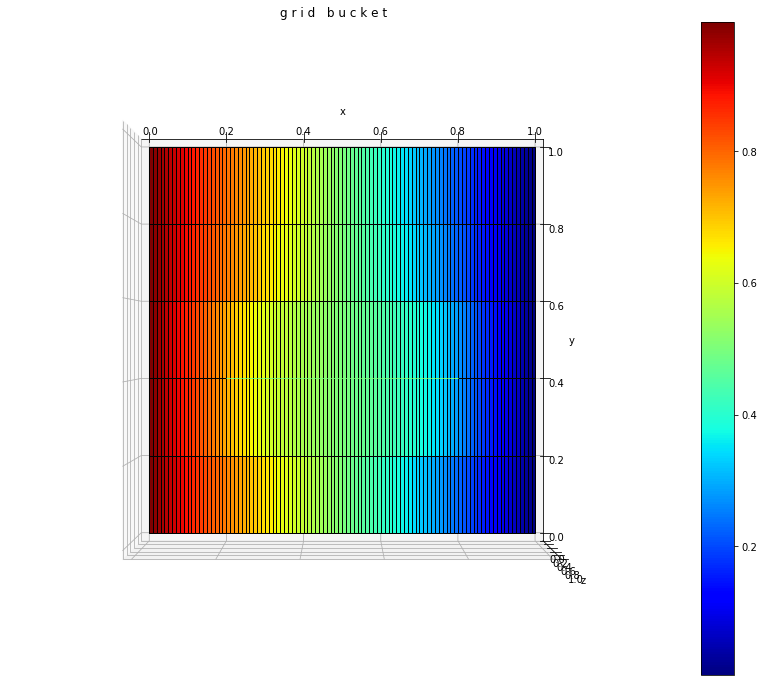

[0.99411071 0.98233424 0.97056407 0.95880444 0.94705964 0.93533405
 0.92363212 0.91195845 0.90031776 0.88871497 0.87715515 0.86564364
 0.85418599 0.84278804 0.83145593 0.82019613 0.8090155  0.79792128
 0.78692116 0.7760233  0.7652364  0.7545697  0.74403047 0.7336242
 0.72335479 0.71322472 0.70323521 0.69338632 0.68367712 0.67410577
 0.66466963 0.65536534 0.64618893 0.63713586 0.62820108 0.61937913
 0.61066416 0.60204996 0.59353007 0.58509772 0.57674596 0.56846763
 0.56025539 0.55210178 0.5439992  0.53593996 0.5279163  0.51992036
 0.51194427 0.5039801  0.4960199  0.48805573 0.48007964 0.4720837
 0.46406004 0.4560008  0.44789822 0.43974461 0.43153237 0.42325404
 0.41490228 0.40646993 0.39795004 0.38933584 0.38062087 0.37179892
 0.36286414 0.35381107 0.34463466 0.33533037 0.32589423 0.31632288
 0.30661368 0.29676479 0.28677528 0.27664521 0.2663758  0.25596953
 0.2454303  0.2347636  0.2239767  0.21307884 0.20207872 0.1909845
 0.17980387 0.16854407 0.15721196 0.14581401 0.13435636 0.1228448

In [5]:
flow=Flow(gb,domain,parameter)
flow.set_data()
flow.discretize()
flow.solve()
flow.plot_pressure()
for g,d in gb:
    print(d[pp.STATE]["pressure"])

In [6]:
parameter={
    "aperture":1e-4,
    "por":0.2,
    "por_frac":0.8,
    #"time_step":1 / 60,
    "time_step":0.01,
    #"t_max":1 /3,
    "t_max":1.0,
    "bc_value":[1.0,0.0],
    "bc_type":['dir','dir'],
    "initial_cond":lambda x,y,z:0.0}

transport=Transport(gb,domain,parameter)
transport.set_data()
transport.get_flux()
transport.discretize()
lhs,rhs_source_adv,rhs_mass,assembler=transport.get_transport_lhs_rhs()

#for g,d in gb:
    #d[pp.PARAMETERS]["transport"]["darcy_flux"]=np.ones(d[pp.PARAMETERS]["transport"]["darcy_flux"].size)
print("darcy_flux")
for g,d in gb:
    print(d[pp.PARAMETERS]["transport"]["darcy_flux"])

mass
  (0, 0)	0.0004
  (1, 1)	0.0004
  (2, 2)	0.0004
  (3, 3)	0.00040000000000000013
  (4, 4)	0.00040000000000000013
  (5, 5)	0.00039999999999999986
  (6, 6)	0.0004000000000000004
  (7, 7)	0.00039999999999999986
  (8, 8)	0.00039999999999999986
  (9, 9)	0.0004000000000000004
  (10, 10)	0.00039999999999999986
  (11, 11)	0.00039999999999999986
  (12, 12)	0.0004000000000000004
  (13, 13)	0.0004000000000000004
  (14, 14)	0.0003999999999999993
  (15, 15)	0.0004000000000000004
  (16, 16)	0.0004000000000000004
  (17, 17)	0.0003999999999999993
  (18, 18)	0.0004000000000000004
  (19, 19)	0.0004000000000000004
  (20, 20)	0.0003999999999999993
  (21, 21)	0.0004000000000000004
  (22, 22)	0.0004000000000000004
  (23, 23)	0.0003999999999999993
  (24, 24)	0.0004000000000000004
  :	:
  (535, 535)	8.000000000000008e-07
  (536, 536)	8.000000000000008e-07
  (537, 537)	7.999999999999919e-07
  (538, 538)	8.000000000000008e-07
  (539, 539)	8.000000000000008e-07
  (540, 540)	8.000000000000008e-07
  (541, 541)

In [7]:
print("tracer_size:")
print(rhs_source_adv.size)

tracer_size:
680


In [8]:
save_every = 1
n_steps = int(np.round(parameter["t_max"] / parameter["time_step"]))

# Initial condition
tracer = np.zeros(rhs_source_adv.size)
assembler.distribute_variable(
    tracer, variable_names=[transport.grid_variable,transport.mortar_variable]
)


# Exporter
exporter = pp.Exporter(gb, file_name="tracer", folder_name="Tracer")
export_fields = ["tracer"]
IEsolver = sps.linalg.factorized(lhs)

/home/dell/.local/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


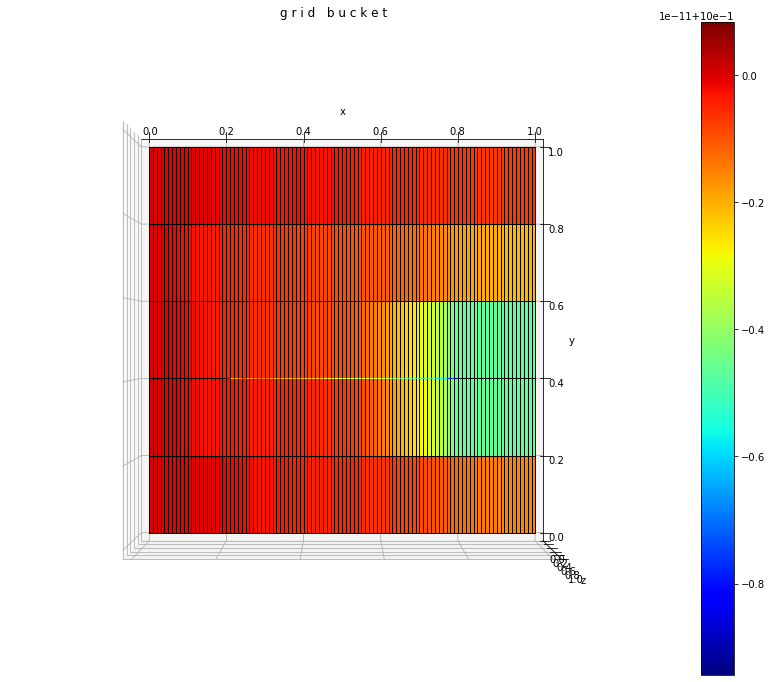

In [9]:
for i in range(n_steps):
    
    if np.isclose(i % save_every, 0):
        # Export existing solution (final export is taken care of below)
        assembler.distribute_variable(
        tracer,
        variable_names=[transport.grid_variable,transport.mortar_variable],
    )
        exporter.write_vtu(export_fields, time_step=int(i // save_every))
    tracer = IEsolver(rhs_mass * tracer + rhs_source_adv)

    
exporter.write_vtu(export_fields, time_step=(n_steps // save_every))
time_steps = np.arange(
    0, parameter["t_max"] + parameter["time_step"], save_every * parameter["time_step"]
)
exporter.write_pvd(time_steps)
transport.plot_tracer()